In [39]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [16]:
#각 레이어 별 Feature Map 출력
def visualize_feature_maps(model, x, layer_names, num_channels=6):
    """
    지정한 레이어 이름에 대한 feature map을 시각화

    Args:
        model: 학습된 CNN 모델
        x: 입력 이미지 (1, 1, 28, 28)
        layer_names: 출력 보고 싶은 레이어 이름 리스트 (예: ["conv_stack.0", "conv_stack.3"])
        num_channels: 시각화할 채널 수
    """
    model.eval()
    device = next(model.parameters()).device
    x = x.unsqueeze(0).to(device)

    feature_maps = {}

    def hook_fn(name):
        def fn(module, input, output):
            feature_maps[name] = output.detach().cpu()
        return fn

    # DataParallel unwrap
    base_model = model.module if isinstance(model, nn.DataParallel) else model

    # Hook 등록
    hooks = []
    for name, module in base_model.named_modules():
        if name in layer_names:
            hooks.append(module.register_forward_hook(hook_fn(name)))

    # Forward 실행
    with torch.no_grad():
        _ = model(x)

    # Hook 해제
    for h in hooks:
        h.remove()

    # 시각화
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, num_channels, figsize=(num_channels * 2, num_layers * 2))
    if num_layers == 1:
        axes = [axes]

    for row_idx, layer_name in enumerate(layer_names):
        fmap = feature_maps[layer_name][0]  # 첫 번째 배치만 시각화
        for ch in range(num_channels):
            ax = axes[row_idx][ch] if num_layers > 1 else axes[ch]
            ax.imshow(fmap[ch], cmap='gray')
            ax.axis("off")
            if ch == 0:
                ax.set_title(layer_name)

    plt.tight_layout()
    plt.show()

In [ ]:
#훈련 데이터셋 로드
training_data=datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)
#테스트 데이터셋 로드
test_data=datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size=128

train_dataloader= DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader= DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [44]:
train_data = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size=128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 141kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.11MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.67MB/s]


In [20]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y:{y.shape}, Type is '{y.dtype}'")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y:torch.Size([128]), Type is 'torch.int64'


In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 모델 정의

In [22]:
class CnnBasedFashion(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 64, kernel_size=3, padding=0),
            nn.ReLU()
        )
        
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x


model = CnnBasedFashion().to(device=device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
    
print(model)

Using 2 GPUs
DataParallel(
  (module): CnnBasedFashion(
    (conv_stack): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
    )
    (fc_stack): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1600, out_features=128, bias=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


## 모델 실험


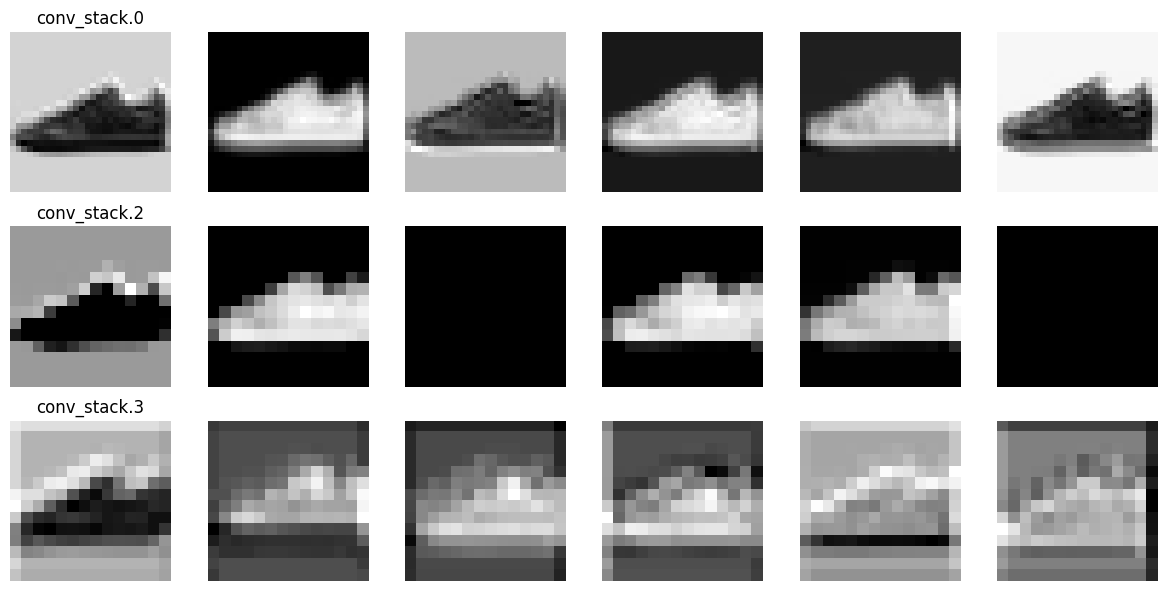

In [23]:
# 입력 이미지
index = 22
x, y = test_data[index]

# 원하는 레이어 출력
visualize_feature_maps(
    model=model,
    x=x,
    layer_names=["conv_stack.0", "conv_stack.2", "conv_stack.3"],  # Conv1, Conv2
    num_channels=6
)


## 모델학습 정의

In [24]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [25]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        #오차 계산
        pred=model(X)
        loss=loss_func(pred, y)
        
        #Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"los: {loss:>7f} [{current:>5d}/{size:5>5d}]")

In [26]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches =len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg Loss: {test_loss:>8f} \n")

## 모델 학습시키기

In [27]:
epoch = 100

for t in range(epoch):
    print(f"Epoch: {t+1}\n---------------------------------------")
    train(train_dataloader, model, loss_func=loss_func, optimizer=optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

Epoch: 1
---------------------------------------
los: 2.306145 [  128/60000]
los: 2.306058 [12928/60000]
los: 2.306226 [25728/60000]
los: 2.294166 [38528/60000]
los: 2.304444 [51328/60000]
Test Error: 
 Accuracy: 11.1%, Avg Loss: 2.303190 

Epoch: 2
---------------------------------------
los: 2.304911 [  128/60000]
los: 2.304804 [12928/60000]
los: 2.305037 [25728/60000]
los: 2.293788 [38528/60000]
los: 2.303434 [51328/60000]
Test Error: 
 Accuracy: 18.1%, Avg Loss: 2.302284 

Epoch: 3
---------------------------------------
los: 2.303977 [  128/60000]
los: 2.303816 [12928/60000]
los: 2.303984 [25728/60000]
los: 2.293483 [38528/60000]
los: 2.302464 [51328/60000]
Test Error: 
 Accuracy: 19.7%, Avg Loss: 2.301359 

Epoch: 4
---------------------------------------
los: 2.303057 [  128/60000]
los: 2.302750 [12928/60000]
los: 2.302815 [25728/60000]
los: 2.293054 [38528/60000]
los: 2.301357 [51328/60000]
Test Error: 
 Accuracy: 19.9%, Avg Loss: 2.300296 

Epoch: 5
---------------------------

batch=32, epoch=10일 경우 소요시간 1분 55초 / 407mb gram 소요

batch=64, epoch=10 일 경우 소요시간 1분 37초 / 409mb gram 소요

batch=128, epoch=10 일 경우 소요시간 1분 25초 / 409mb gram 소요

batch=64, epoch=100 일 경우 소요시간 28분 14초 / 정확도: 83.2%

## 모델 저장하기

In [32]:
torch.save(model.state_dict(), "checkpoints/cnn_model.pth")
print("Model saved...")

Model saved...


## 모델 불러오기

In [33]:
model =CnnBasedFashion()
model =nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load("checkpoints/cnn_model_100e64b.pth"))

<All keys matched successfully>

## 모델 추론하기

In [38]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
index = 160
x, y = test_data[index][0], test_data[index][1]
with torch.no_grad():
    x = x.unsqueeze(0).to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Sneaker", Actual: "Sneaker"


In [31]:
"""def clear_gpu_memory():
    import gc
    import torch

    globals_to_clear = ['model', 'x', 'y', 'pred']  # 전역 네임스페이스에 등록된 이름도 삭제
    for name in globals_to_clear:
        if name in globals():
            globals()[name] = None

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print("🧹 GPU memory cleared!")

clear_gpu_memory()"""

'def clear_gpu_memory():\n    import gc\n    import torch\n\n    globals_to_clear = [\'model\', \'x\', \'y\', \'pred\']  # 전역 네임스페이스에 등록된 이름도 삭제\n    for name in globals_to_clear:\n        if name in globals():\n            globals()[name] = None\n\n    gc.collect()\n    torch.cuda.empty_cache()\n    torch.cuda.ipc_collect()\n    print("🧹 GPU memory cleared!")\n\nclear_gpu_memory()'